In [11]:
import torch
import numpy as np
import cv2
import os
import csv
import matplotlib.pyplot as plt

import multiprocessing as mp

In [2]:
def GetAvgWidth(seqs):
    
    alpha = 46.5 / 64.0
    beta = 58.0 / 64.0
    
    T = len(seqs)
    H, W = seqs[0].size()
    
    avgWidth = torch.zeros(T)
    
    for t in range(T):
        y = seqs[t].sum(dim=1).numpy()
        y_top = (y!=0).argmax(axis=0)
        y_btm = (y!=0).cumsum(axis=0).argmax(axis=0)
        
        if (y_top == y_btm):
            continue
            
        low = (y_top + (y_btm - y_top)*alpha).round().astype(int)
        high = (y_top + (y_btm - y_top)*beta).round().astype(int)
        
        cnt = 0
        for i in range(low, high, 1):
            for w in range(W):
                if ( seqs[t][i][w] != 0 ):
                    pre = w
                    break
                    
            for w in range(W-1, 0, -1):
                if ( seqs[t][i][w] != 0 ):
                    avgWidth[t] = avgWidth[t] + w - pre
                    cnt += 1
        if (cnt != 0):
            avgWidth[t] = avgWidth[t] / cnt
        else:
            avgWidth[t] = -1
            
    return avgWidth

In [23]:
def GetKeyFrame(period):

    N = period.size(0)
    
    keyFrame = []
    delta = 7
    cur = 0
    while (cur < N):
        for i in range(cur-delta, cur+delta, 1):
            
            if ((i < 0) or (i >= N) or (i==cur)):
                continue
                
            if (period[i] < period[cur]):
                continue
            else:
                break
                
        if (i+1) == cur+delta:
            keyFrame.append(cur)
        cur += 1
    
    return keyFrame

In [4]:
def GetPeriod(seqs):
    
    period = GetAvgWidth(seqs)
    
    tmp = period[period > 0]
    
    period = (period - torch.min(tmp)) / (torch.max(tmp) - torch.min(tmp))
    keyFrame = GetKeyFrame(period)
    
    return period, keyFrame

In [5]:
def ParPeriod(seqs, size_window, num_channels, period):
    
    pei = torch.zeros(num_channels, 64, 64, dtype=torch.float32)
    
    for i in range(num_channels):
        left = i / (num_channels + 1)
        right = left + size_window / 2
        left = left - size_window / 2
        
        idx = (period >= left) & (period <= right)
        
        tmp = torch.zeros(1, 64, 64, dtype=torch.float32)
        for j in range(len(idx)):
            if idx[j] == 1:
                tmp += seqs[j].float()
        pei[i] = tmp / torch.sum(idx)
        #pei[i] = torch.sum(seqs[idx], dim=1) / torch.sum(idx)
        
    return pei

In [49]:
def CropPedestrian(img, target_size):
    
    y = img.sum(axis=1)
    y_top = (y!=0).argmax(axis=0)
    y_btm = (y!=0).cumsum(axis=0).argmax(axis=0)
    
    height = y_btm - y_top
    
    asp_ratio = img.shape[1] / img.shape[0]
    width = int(height * asp_ratio)
    
    sum_col = img.sum(axis=0).cumsum(axis=0)
    x_thres = img.sum() / 2
    x_center = -1
    for i in range(len(sum_col)):
        if sum_col[i] > x_thres:
            x_center = i
            break
            
    x_left = x_center - (width // 2)
    x_right = x_center + (width // 2)
    
    if ( x_left < 0 ):
        H,W = img.shape
        tmp = np.zeros((H, W + abs(x_left)))
        tmp[:, abs(x_left):] = img
        tmp = tmp[y_top:y_btm, 0:x_right+x_left]
    else:
        tmp = img[y_top:y_btm, x_left:x_right]  
    
    cropped = cv2.resize(tmp, (target_size, target_size), interpolation=cv2.INTER_AREA)
    cropped = torch.from_numpy(cropped)
    
    return cropped

In [21]:
def BuildPEI(seqs, size_window, num_channels):
    
    seq_length = len(seqs)
    
    if seq_length == 0:
        return torch.zeros(num_channels, 64, 64)
    
    for i in range(seq_length):
        seqs[i] = CropPedestrian(seqs[i], 64)
        
    period, key_frame = GetPeriod(seqs)
    
    if len(key_frame) == 0:
        return
    start = key_frame[0]
    end = key_frame[len(key_frame) - 1]
    
    tmp = seqs[start:end]
    period = period[start:end]
    
    pei = ParPeriod(tmp, size_window, num_channels, period)
    
    return pei

In [8]:
def zero_pad(num, digit=3):
    n_str = str(num)
    while len(n_str) < digit:
        n_str = "0" + n_str
    return n_str

In [9]:
with open('./data/OU_ISIR/ID_list.csv', 'r') as ID_list:
    lines = ID_list.readlines()
    
cooked = csv.reader(lines)
train_IDs = []
test_IDs = []
for record in cooked:
    if record[0] == 'Training subject ID' or record[0] == '':
        continue
    train_IDs.append(int(record[0]))
    test_IDs.append(int(record[1]))

In [52]:
root_path = './data/OU_ISIR/raw/'

os.makedirs( root_path.replace('raw', 'npy'), exist_ok=True)

pool = mp.Pool(processes=6)

for view in os.listdir(root_path):
    
    view_path = os.path.join(root_path, view)
    
    for idx in range(1000):
        label_path = os.path.join(view_path, zero_pad(train_IDs[idx], 5))
        
        if not os.path.exists(label_path):
            continue
            
        if os.path.exists('./data/OU_ISIR/npy/{}/{}.npy'.format(view[-6:], zero_pad(train_IDs[idx], 5))):
            continue
        
        seqs = []        
        for file in os.listdir(label_path):
            
            img = cv2.imread( os.path.join(label_path, file))
            if img is None:
                continue
            seqs.append(img[:,:,0])
        
        pei = BuildPEI(seqs, 0.4, 5)
        
        os.makedirs('./data/OU_ISIR/npy/{}'.format(view[-6:]), exist_ok=True)
        np.save('./data/OU_ISIR/npy/{}/{}'.format(view[-6:], zero_pad(train_IDs[idx], 5)), pei)
        
pool.close()
pool.join()

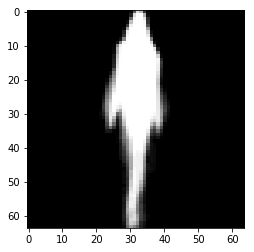

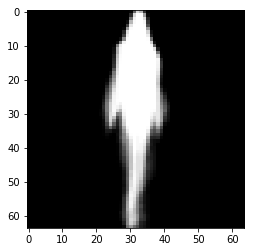

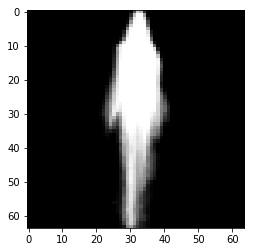

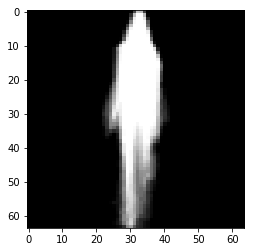

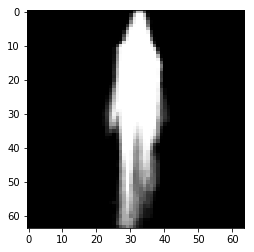

In [27]:
pei = np.load('./data/OU_ISIR/npy/015-00/00303.npy')

for c in range(5):
    plt.imshow(pei[c], cmap='gray')
    plt.show()